## Time series prediction for power plants

In [1]:
import pandas as pd
from fbprophet import Prophet

In [2]:
p50187 = pd.read_csv('plantid50187.csv')
p50187.columns = ['ds', 'y']

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


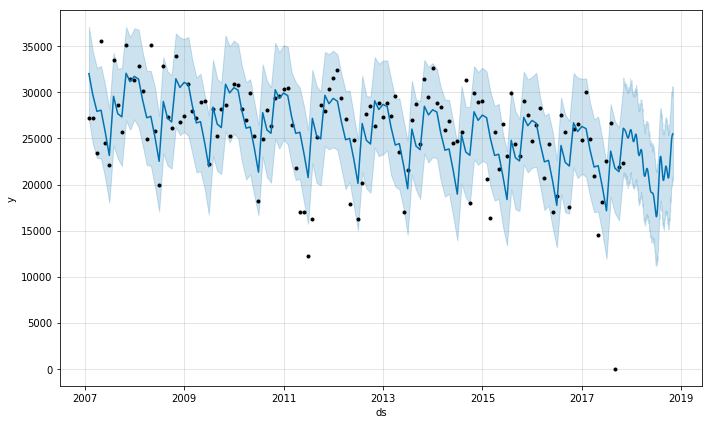

In [11]:
m = Prophet()
m.fit(p50187);
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

m.plot(forecast);

In [15]:
forecast.to_csv('forecast' + 'plantid50187.csv', index = False)

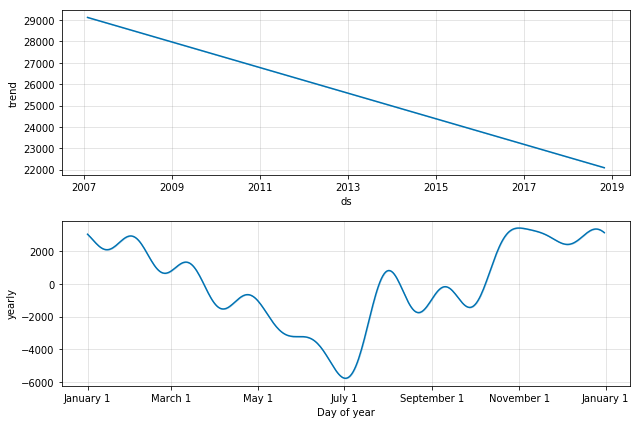

In [16]:
m.plot_components(forecast);

In [17]:
p3845 = pd.read_csv('plantid3845.csv')
p3845.columns = ['ds', 'y']

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


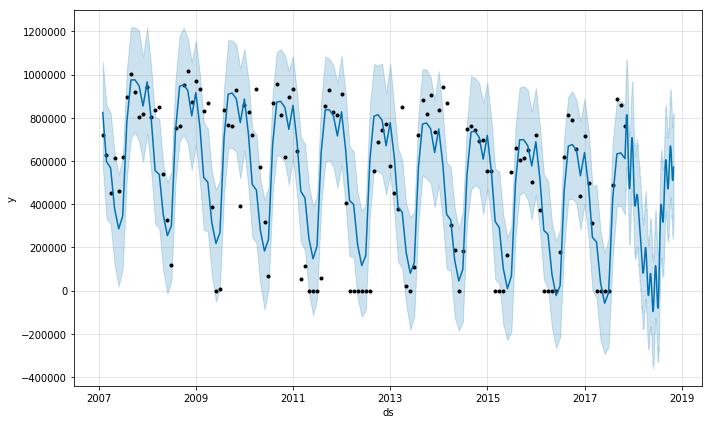

In [18]:
m = Prophet()
m.fit(p3845);
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
m.plot(forecast);

In [19]:
forecast.to_csv('forecast' + 'plantid3845.csv', index = False)

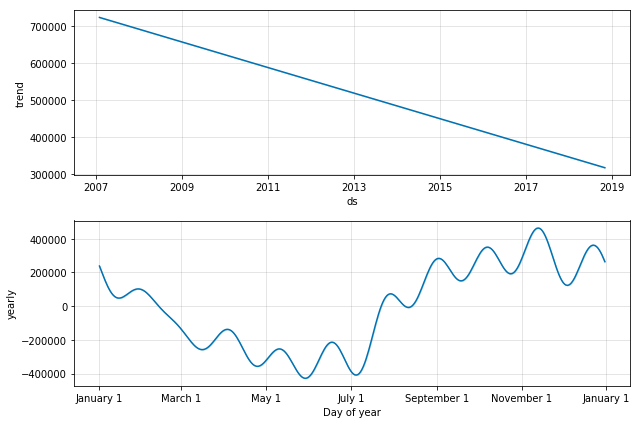

In [20]:
m.plot_components(forecast);

In [21]:
p54268 = pd.read_csv('plantid54268.csv')
p54268.columns = ['ds', 'y']

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


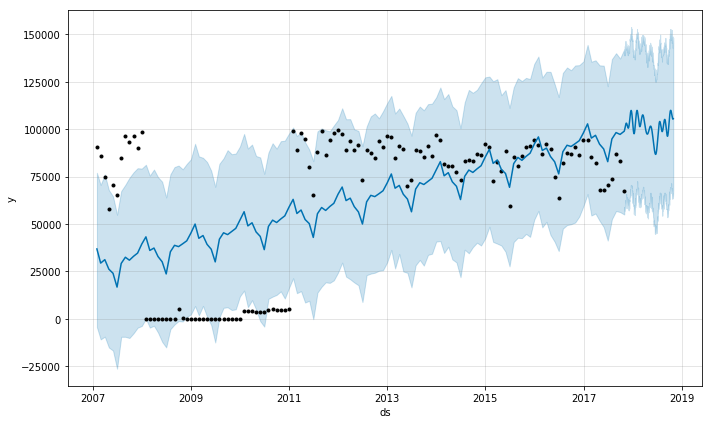

In [22]:
m = Prophet()
m.fit(p54268);
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
m.plot(forecast);

In [23]:
forecast.to_csv('forecast' + 'plantid54268.csv', index = False)

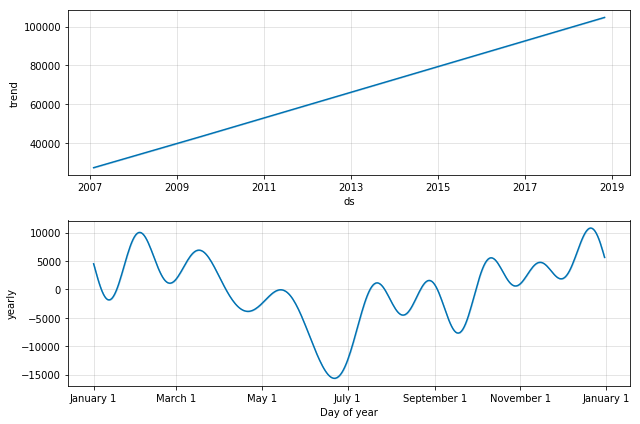

In [24]:
m.plot_components(forecast);